# Automatic Differentiation

## Import `autograd` and create a variable

In [9]:
!pip install mxnet
!pip install d2l

  Created wheel for d2l: filename=d2l-0.10.1-cp36-none-any.whl size=16622 sha256=820274098017b99f9205bdbf4bf22c95838c2917baa490582aa87a6067f660fe
  Stored in directory: /root/.cache/pip/wheels/60/35/5d/df7f13dd4b012de688ffcc516091c6cd67c765dc64c9d1f43f
Successfully built d2l


In [10]:
from mxnet import autograd, nd
import d2l

x = nd.arange(4).reshape((4, 1))
print(x) 


[[0.]
 [1.]
 [2.]
 [3.]]
<NDArray 4x1 @cpu(0)>


## Attach gradient to `x`

- It allocates memory to store its gradient, which has the same shape as `x`. 
- It also tell the system that we need to compute its gradient.

In [0]:
x.attach_grad()
x.grad


[[0.]
 [0.]
 [0.]
 [0.]]
<NDArray 4x1 @cpu(0)>

## Forward

Now compute 

$$y = 2\mathbf{x}^{\top}\mathbf{x}$$

by placing code inside a ``with autograd.record():`` block. MXNet will build the according computation graph. 

In [0]:
with autograd.record():
    y = 2 * nd.dot(x.T, x)
y


[[28.]]
<NDArray 1x1 @cpu(0)>

## Backward

In [0]:
y.backward()

## Get the gradient

Given $y = 2\mathbf{x}^{\top}\mathbf{x}$, we know 

$$\frac{\partial y}{\partial \mathbf x} = 4\mathbf{x}$$

Now verify the result:

In [0]:
print((x.grad - 4 * x).norm().asscalar() == 0)
print(x.grad)

True

[[ 0.]
 [ 4.]
 [ 8.]
 [12.]]
<NDArray 4x1 @cpu(0)>


## Backward on non-scalar

`y.backward()` equals to `y.sum().backward()`


In [0]:
with autograd.record():
    y = 2 * x * x
print(y.shape)
y.backward()
print(x.grad)

(4, 1)

[[ 0.]
 [ 4.]
 [ 8.]
 [12.]]
<NDArray 4x1 @cpu(0)>


## Training mode and prediction mode

The `record` scope will alter the mode by assuming that gradient is only required for training. 

It's necessary since some layers, e.g. batch normalization, behavior differently in the training and prediction modes.

In [0]:
print(autograd.is_training())
with autograd.record():
    print(autograd.is_training())

False
True


## Computing the hradient of Python control flow

Autograd also works with Python functions and control flows.

In [0]:
def f(a):
    b = a * 2
    while b.norm().asscalar() < 1000:
        b = b * 2
    if b.sum().asscalar() > 0:
        c = b
    else:
        c = 100 * b
    return c

## Function behaviors depends on inputs

In [0]:
a = nd.random.normal(shape=1)
a.attach_grad()
with autograd.record():
    d = f(a)
d.backward()

## Verify the results


`f` is piecewise linear in its input `a`. There exists $g$ such as $f(a) = g a$ and $\frac{\partial f}{\partial a}=g$. Verify the result:

In [0]:
print(a.grad == (d / a))


[1.]
<NDArray 1 @cpu(0)>


## Head gradients and the chain rule

We can break the chain rule manually. Assume $\frac{\partial z}{\partial x} = \frac{\partial z}{\partial y}\frac{\partial y}{\partial x}.$ `y.backward()` will only compute $\frac{\partial y}{\partial x}$. To get $\frac{\partial z}{\partial x}$, we can first compute $\frac{\partial z}{\partial y}$, and then pass it as head gradient to `y.backward`.

In [0]:
with autograd.record():
    y = x * 2
y.attach_grad()
with autograd.record():
    z = y * x
z.backward()  # y.grad = \partial z / \partial y
y.backward(y.grad)
x.grad == 2*x # x.grad = \partial z / \partial x


[[1.]
 [1.]
 [1.]
 [1.]]
<NDArray 4x1 @cpu(0)>

##Sigmoid Function
The sigmoid function transforms its inputs which take values in R to the interval (0,1)

. For that reason, the sigmoid is often called a squashing function: it squashes any input in the range (-inf, inf) to some value in the range (0,1).
¶
$sigmoid(x)=\frac{1}{1+exp(−x)}$.
See the sigmoid function plotted below. When the input is close to 0, the sigmoid function approaches a linear transformation.

In [0]:
x = nd.arange(-8.0, 8.0, 0.1)
x.attach_grad()

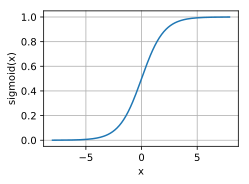

In [12]:
with autograd.record():
    y = x.sigmoid()
d2l.plot(x, y, 'x', 'sigmoid(x)')

The derivative of sigmoid function is given by the following equation:

$\frac{d}{dx} \mathrm{sigmoid}(x) = \frac{\exp(-x)}{(1 + \exp(-x))^2} = \mathrm{sigmoid}(x)\left(1-\mathrm{sigmoid}(x)\right).$
The derivative of sigmoid function is plotted below. Note that when the input is 0, the derivative of the sigmoid function reaches a maximum of 0.25. As the input diverges from 0 in either direction, the derivative approaches 0.

In [0]:
y.backward()
d2l.plot(x, x.grad, 'x', 'grad of sigmoid')

##Tanh Function
Like the sigmoid function, the tanh (Hyperbolic Tangent) function also squashes its inputs, transforms them into elements on the interval between -1 and 1:
$\text{tanh}(x) = \frac{1 - \exp(-2x)}{1 + \exp(-2x)}.$

We plot the tanh function blow. Note that as the input nears 0, the tanh function approaches a linear transformation. Although the shape of the function is similar to the sigmoid function, the tanh function exhibits point symmetry about the origin of the coordinate system.

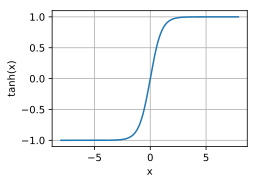

In [16]:
with autograd.record():
    y = x.tanh()
d2l.plot(x, y, 'x', 'tanh(x)')

The derivative of the Tanh function is:

$\frac{d}{dx} \mathrm{tanh}(x) = 1 - \mathrm{tanh}^2(x).$

The derivative of tanh function is plotted below. As the input nears 0, the derivative of the tanh function approaches a maximum of 1. And as we saw with the sigmoid function, as the input moves away from 0 in either direction, the derivative of the tanh function approaches 0.


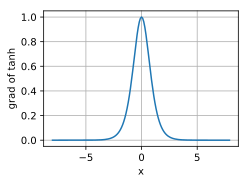

In [17]:
y.backward()
d2l.plot(x, x.grad, 'x', 'grad of tanh')

##ReLU Function
$\mathrm{ReLU}(z) = \max(z, 0).$

It can be understood that the ReLU function retains only positive elements and discards negative elements (setting those nodes to 0). To get a better idea of what it looks like, we can plot it.

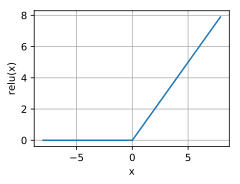

In [18]:
x = nd.arange(-8.0, 8.0, 0.1)
x.attach_grad()
with autograd.record():
    y = x.relu()
d2l.set_figsize((4, 2.5))
d2l.plot(x, y, 'x', 'relu(x)')

Note that the ReLU function is not differentiable when the input takes value precisely equal to 0. In these cases, we go with the left-hand-side (LHS) derivative and say that the derivative is 0 when the input is 0. 

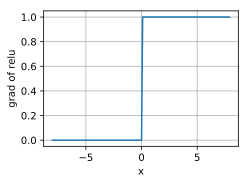

In [19]:
y.backward()
d2l.plot(x, x.grad, 'x', 'grad of relu')